

Your task is to beat all benchmarks in this competition. Here you won’t be provided with detailed instructions. Hopefully, at this stage of the course, it's enough for you to take a quick look at the data in order to understand that this is the type of task where gradient boosting will do. Most likely it will be LightGBM. But you can try Xgboost or Catboost as well.

<img src="https://habrastorage.org/webt/fs/42/ms/fs42ms0r7qsoj-da4x7yfntwrbq.jpeg" width=30% />

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

import os
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import lightgbm as lgb

import time

In [2]:
PATH = '../../data'
train_df = pd.read_csv('../../data/flight_delays_train.csv')
test_df = pd.read_csv('../../data/flight_delays_test.csv')
train_df.shape, test_df.shape

((100000, 9), (100000, 8))

In [3]:
categorical_vars = train_df.describe(include=["object"]).columns[:-1]
continuous_vars = train_df.describe().columns

In [4]:
categorical_vars

Index(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'], dtype='object')

In [5]:
continuous_vars

Index(['DepTime', 'Distance'], dtype='object')

In [6]:
# Creating dummy variables
data_dummies_df = pd.get_dummies(train_df, columns=categorical_vars, drop_first=True)
holdout_dummies_df = pd.get_dummies(test_df, columns=categorical_vars, drop_first=True)

In [7]:
# data_dummies_df.head()

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
Month                100000 non-null object
DayofMonth           100000 non-null object
DayOfWeek            100000 non-null object
DepTime              100000 non-null int64
UniqueCarrier        100000 non-null object
Origin               100000 non-null object
Dest                 100000 non-null object
Distance             100000 non-null int64
dep_delayed_15min    100000 non-null object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [9]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [11]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [57]:
train_df['DepTime'] = train_df['DepTime'].apply(lambda x: x-2400 if x >= 2400 else x)
test_df['DepTime'] = test_df['DepTime'].apply(lambda x: x-2400 if x >= 2400 else x)
train_df.shape, test_df.shape

((100000, 9), (100000, 8))

In [59]:
train_df['Month'] = train_df['Month'].apply(lambda x: str(x)[2:]).astype('int')
train_df['DayOfWeek'] = train_df['DayOfWeek'].apply(lambda x: str(x)[2:]).astype('int')
train_df['DayofMonth'] = train_df['DayofMonth'].apply(lambda x: str(x)[2:]).astype('int')
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,N
1,4,20,3,1548,US,PIT,MCO,834,N
2,9,2,5,1422,XE,RDU,CLE,416,N
3,11,25,6,1015,OO,DEN,MEM,872,N
4,10,7,6,1828,WN,MDW,OMA,423,Y


In [60]:
test_df['Month'] = test_df['Month'].apply(lambda x: str(x)[2:]).astype('int')
test_df['DayOfWeek'] = test_df['DayOfWeek'].apply(lambda x: str(x)[2:]).astype('int')
test_df['DayofMonth'] = test_df['DayofMonth'].apply(lambda x: str(x)[2:]).astype('int')
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,7,25,3,615,YV,MRY,PHX,598
1,4,17,2,739,WN,LAS,HOU,1235
2,12,2,7,651,MQ,GSP,ORD,577
3,3,25,7,1614,WN,BWI,MHT,377
4,6,6,3,1505,UA,ORD,STL,258


In [61]:
full_df = pd.concat([train_df, test_df])

In [62]:
full_df.head()

,DayOfWeek,DayofMonth,DepTime,Dest,Distance,Month,Origin,UniqueCarrier,dep_delayed_15min
0,7,21,1934,DFW,732,8,ATL,AA,N
1,3,20,1548,MCO,834,4,PIT,US,N
2,5,2,1422,CLE,416,9,RDU,XE,N
3,6,25,1015,MEM,872,11,DEN,OO,N
4,6,7,1828,OMA,423,10,MDW,WN,Y


In [63]:
delayed = train_df[train_df['dep_delayed_15min']==1]
delayed.head()
top_10_delayed = delayed.groupby('UniqueCarrier')['dep_delayed_15min'].size().sort_values(ascending=False).head(10)
top_10_delayed
top_10_delayed = top_10_delayed.index.values# loc['AA']#[top_10_delayed == 'AA']

In [64]:
uniq_carrier_encoder = OneHotEncoder()
uniq_carrier_encoder.fit(full_df[['UniqueCarrier']])

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [65]:
origin_encoder = OneHotEncoder()
origin_encoder.fit(full_df[['Origin']])

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [66]:
dest_encoder = OneHotEncoder()
dest_encoder.fit(full_df[['Dest']])

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

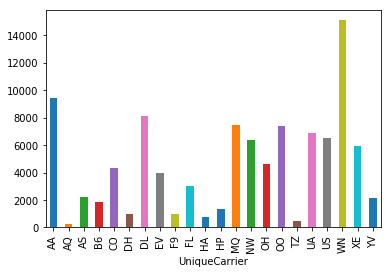

In [69]:
train_df.groupby('UniqueCarrier').size().plot(kind='bar');

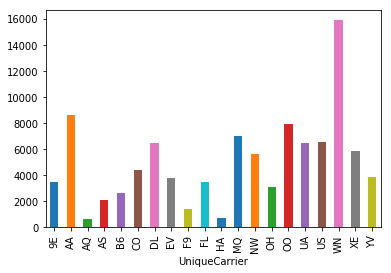

In [70]:
test_df.groupby('UniqueCarrier').size().plot(kind='bar');

Given flight departure time, carrier's code, departure airport, destination location, and flight distance, you have to predict departure delay for more than 15 minutes. As the simplest benchmark, let's take logistic regression and two features that are easiest to take: DepTime and Distance. This will correspond to **"simple logit baseline"** on Public LB.

In [71]:
X_train, y_train = train_df[['Distance', 'DepTime']].values, train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test_df[['Distance', 'DepTime']].values

X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=17)

In [72]:
logit_pipe = Pipeline([    
    ('scaler', StandardScaler()),
#     ('poly', PolynomialFeatures(degree=2)),
    ('logit', LogisticRegression(C=1, random_state=17, solver='liblinear'))])

In [73]:
logit_pipe.fit(X_train_part, y_train_part)
logit_valid_pred = logit_pipe.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

0.67881030649159979

In [74]:
logit_pipe.fit(X_train, y_train)
logit_test_pred = logit_pipe.predict_proba(X_test)[:, 1]

pd.Series(logit_test_pred, 
          name='dep_delayed_15min').to_csv('logit_2feat.csv', 
                                           index_label='id', header=True)

Now you have to beat **"A10 benchmark"** on Public LB. It's not challenging at all. Go for LightGBM, maybe some other models (or ensembling) as well. Include categorical features, do some simple feature engineering as well. Good luck!

In [75]:
train_df['dep_delayed_15min'] = pd.Categorical(train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}))

In [76]:
# Special transformer to save output shape
class ShapeSaver(BaseEstimator, TransformerMixin):
    def transform(self, X):
        self.shape = X.shape
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [77]:
def write_submission_file(prediction,
                          filename,
                          path_to_sample=os.path.join(
                                  PATH,
                                  'sample_submission.csv')):
    pd.Series(prediction, 
              name='dep_delayed_15min').to_csv(filename, 
                                               index_label='id', 
                                               header=True)

In [78]:
# --------------------------------------------------------------------------
def src_to_pred(x):
     return x

# --------------------------------------------------------------------------
def pred_to_src(x):
    return x

In [79]:
def train_lgm(Xtrain, ytrain, Xvalid, yvalid, Xtest):
    experiment_name = 'train_lgm' + time.strftime("%d_%m_%Y_%H_%M_%S")
    experiment = {}
    experiment['time'] = experiment_name

    print(Xtrain.shape)

    experiment['transformed_train_df_shape'] = Xtrain.shape
    experiment['features'] = [
            v[0] for v in transform_pipeline.steps[0][1].transformer_list]

    lgb_x_train_part = lgb.Dataset(
            Xtrain.astype(np.float32),
            label=src_to_pred(ytrain))

    lgb_x_valid = lgb.Dataset(
            Xvalid.astype(np.float32),
            label=src_to_pred(yvalid))

    param = {'num_leaves': 31,
             'num_trees': 500,
             'objective': 'binary',
#              'metric': 'l2'
            }

    param = {
        'num_trees': 500,
        'objective' :'binary',
        'num_leaves' : 31,
#         'max_depth': 50,
        'reg_alpha': 0.701,
#         'feature_fraction': 0.55,
        }
    
    num_round = 100
    bst_lgb = lgb.train(param,
                        lgb_x_train_part,
                        num_round,
                        valid_sets = [lgb_x_valid],
                        early_stopping_rounds=20,
                        verbose_eval=0)

    lgb_pred = pred_to_src(
            bst_lgb.predict(
                    Xvalid.astype(np.float32),
                    num_iteration = bst_lgb.best_iteration))

    lgb_valid_mae = roc_auc_score(yvalid, lgb_pred)
    print('LGM valid roc_auc: {}'.format(lgb_valid_mae))

    experiment['clf'] = 'lgm'
    experiment['valid_roc_auc'] = lgb_valid_mae
    experiment['np.expm1_valid_roc_auc'] = pred_to_src(lgb_valid_mae)

    lgb_test_pred = pred_to_src(bst_lgb.predict(Xtest.astype(np.float32)))

    return bst_lgb, lgb_pred, experiment, lgb_test_pred

# --------------------------------------------------------------------------
def full_lgm_fit(clf, Xtrain, ytrain, Xtest):
    lgb_x_train_part = lgb.Dataset(
            Xtrain.astype(np.float32),
            label=src_to_pred(ytrain))

    bst_lgb = lgb.train(clf.params,
                        lgb_x_train_part
                        )

    lgb_pred = pred_to_src(
            bst_lgb.predict(
                    Xtest.astype(np.float32),
                    num_iteration = bst_lgb.best_iteration))

    return bst_lgb, lgb_pred

# --------------------------------------------------------------------------
def full_fit(clf, Xtrain, ytrain, Xtest):
    clf.fit(Xtrain, src_to_pred(ytrain))
    if hasattr(clf, 'predict_proba'):
        clf_test_pred = pred_to_src(clf.predict_proba(Xtest))[:, 1]
    else:
        clf_test_pred = pred_to_src(clf.predict(Xtest))
    return clf, clf_test_pred

# --------------------------------------------------------------------------
def train_clf(clf, Xtrain, ytrain, Xvalid, yvalid, Xtest, clf_name):
    experiment_name = clf_name + time.strftime("%d_%m_%Y_%H_%M_%S")
    experiment = {}
    experiment['time'] = experiment_name

    print(Xtrain.shape)

    experiment['transformed_train_df_shape'] = Xtrain.shape
    experiment['features'] = [v[0] for v in transform_pipeline.steps[0][1].transformer_list]

    clf.fit(Xtrain, src_to_pred(ytrain))
    if hasattr(clf, 'predict_proba'):
        clf_pred = pred_to_src(clf.predict_proba(Xvalid))[:, 1]
    else:
        clf_pred = pred_to_src(clf.predict(Xvalid))

    valid_mae = roc_auc_score(yvalid, clf_pred)
    print('{} valid mae: {}'.format(clf_name, valid_mae))

    experiment['clf'] = clf_name
    experiment['valid_roc_auc'] = valid_mae
    experiment['np.expm1_valid_mae'] = pred_to_src(valid_mae)

    if hasattr(clf, 'predict_proba'):
        clf_test_pred = pred_to_src(clf.predict_proba(Xtest))[:, 1]
    else:
        clf_test_pred = pred_to_src(clf.predict(Xtest))

    return clf, clf_pred, experiment, clf_test_pred

In [80]:

# --------------------------------------------------------------------------
def full_lgm_fit_cv(clf, Xtrain, ytrain, Xtest):

    bst_lgb = clf.fit(Xtrain.astype(np.float32), src_to_pred(ytrain))

    lgb_pred = pred_to_src(
            bst_lgb.predict(
                    Xtest.astype(np.float32),
                    num_iteration = bst_lgb.best_iteration))

    return bst_lgb, lgb_pred

# --------------------------------------------------------------------------
def train_clf_cv(clf, cv, Xtrain, ytrain, Xvalid, yvalid, Xtest, clf_name,
                 grid_params):
    experiment_name = clf_name + time.strftime("%d_%m_%Y_%H_%M_%S")
    experiment = {}
    experiment['time'] = experiment_name

    print(Xtrain.shape)

    experiment['transformed_train_df_shape'] = Xtrain.shape
    experiment['features'] = [v[0] for v in transform_pipeline.steps[0][1].transformer_list]

    clf_grid = GridSearchCV(
        estimator=clf,
        param_grid=grid_params,
        n_jobs=-1,
        cv=cv,
        verbose=10,
        scoring='roc_auc')

    clf_grid.fit(Xtrain, src_to_pred(ytrain))
    if hasattr(clf_grid, 'predict_proba'):
        clf_pred = pred_to_src(clf_grid.predict_proba(Xvalid))[:, 1]
    else:
        clf_pred = pred_to_src(clf_grid.predict(Xvalid))

    valid_mae = roc_auc_score(yvalid, clf_pred)
    print('{} valid roc_auc: {}'.format(clf_name, valid_mae))

    experiment['clf'] = clf_name
    experiment['valid_roc_auc'] = valid_mae
    experiment['np.expm1_valid_mae'] = pred_to_src(valid_mae)

    if hasattr(clf_grid, 'predict_proba'):
        clf_test_pred = pred_to_src(clf_grid.predict_proba(Xtest))[:, 1]
    else:
        clf_test_pred = pred_to_src(clf_grid.predict(Xtest))

    return clf_grid, clf_pred, experiment, clf_test_pred


# --------------------------------------------------------------------------
def train_ridge_cv(cv, Xtrain, ytrain, Xvalid, yvalid, Xtest):
    clf = Ridge(random_state = 17, alpha=1.35)
    grid_params = {
            'alpha': [1e-10, 1e-2, 1, 1.35, 5],
#            'solver' : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
            }
    return train_clf_cv(clf, cv, Xtrain, ytrain, Xvalid, yvalid, Xtest,
                        'train_ridge',
                        grid_params=grid_params)

# --------------------------------------------------------------------------
def train_lgm_cv(cv, Xtrain, ytrain, Xvalid, yvalid, Xtest):
    
    params = {'boosting_type': 'gbdt',
              'max_depth' : 100,
              'objective': 'binary',
              'nthread': -1,
              'num_leaves': 31,
              'learning_rate': 0.05,
              'max_bin': 512,
              'subsample_for_bin': 200,
              'subsample': 1,
              'subsample_freq': 1,
              'colsample_bytree': 0.8,
              'reg_alpha': 5,
              'reg_lambda': 10,
              'min_split_gain': 0.5,
              'min_child_weight': 1,
              'min_child_samples': 5,
              'scale_pos_weight': 1,
              'num_class' : 1,
              'metric' : 'auc',
              'eval_metric': 'auc'}

#     params = {'num_leaves': 31,
#              'num_trees': 500,
#              'objective': 'binary',
#             }
    
    # Create parameters to search
    gridParams = {
#         'learning_rate': [0.005],
        'n_estimators': [500],
        'num_leaves': [31],
#         'boosting_type' : ['gbdt'],
        'objective' : ['binary'],
        'random_state' : [17],
#         'colsample_bytree' : [0.65, 0.66],
#         'subsample' : [0.7,0.75],
#         'reg_alpha' : [1,1.2],
#         'reg_lambda' : [1,1.2,1.4],
        }

    clf = lgb.LGBMClassifier(
        random_state=17,
        boosting_type= 'gbdt',
        objective = 'binary',
        n_jobs = -1, 
#         silent = True,
         max_depth = params['max_depth'],
#         max_bin = params['max_bin'],
#         subsample_for_bin = params['subsample_for_bin'],
#         subsample = params['subsample'],
#         subsample_freq = params['subsample_freq'],
#         min_split_gain = params['min_split_gain'],
#         min_child_weight = params['min_child_weight'],
#         min_child_samples = params['min_child_samples'],
#         scale_pos_weight = params['scale_pos_weight']
    )
    
    return train_clf_cv(clf, cv, Xtrain, ytrain, Xvalid, yvalid, Xtest,
                        'train_lgm',
                        grid_params=gridParams)


In [94]:
def extract_month(X):
    return X[['Month']]

def extract_distance(X):
    return X[['Distance']]

def extract_deptime(X):
    return X[['DepTime']]

def extract_deptime_hour(X):
    hour = (X['DepTime']/100).astype(int)
    return pd.DataFrame(hour)

def extract_origin(X):
    return origin_encoder.transform(X[['Origin']])

def extract_dest(X):
    return dest_encoder.transform(X[['Dest']])

def extract_carrier(X):
    return uniq_carrier_encoder.transform(X[['UniqueCarrier']])

def is_in_top_10_delay_carrier(X):
    is_in_top_delayed = X['UniqueCarrier'].isin(top_10_delayed)
    return pd.DataFrame(is_in_top_delayed)

def extract_day_of_month(X):
    return X[['DayofMonth']]

def extract_day_of_week(X):
    return X[['DayOfWeek']]

def extract_deptime_night(X):
    hour = (X['DepTime']/100).astype(int)
    return pd.DataFrame((0 <= hour) & (hour < 8))

def extract_deptime_morning(X):
    hour = (X['DepTime']/100).astype(int)
    return pd.DataFrame((8 <= hour) & (hour < 12))

def extract_deptime_day(X):
    hour = (X['DepTime']/100).astype(int)
    return pd.DataFrame((12 <= hour) & (hour < 18))

def extract_deptime_eve(X):
    hour = (X['DepTime']/100).astype(int)
    return pd.DataFrame((18 <= hour) & (hour <= 24))

def extract_long_distance(X):
    distance = X['Distance'].astype(int)
    return pd.DataFrame(distance > 500)


In [101]:
distance =  Pipeline([
    ('extract', FunctionTransformer(extract_distance, validate=False)),
    ('scale', StandardScaler()),
    ])

deptime = Pipeline([
    ('extract', FunctionTransformer(extract_deptime, validate=False)),
    ('poly', PolynomialFeatures(degree=3)),
    ('scale', StandardScaler()),
    ])

deptime_hour = Pipeline([
    ('extract', FunctionTransformer(extract_deptime_hour, validate=False)),
    ('ohe', OneHotEncoder()),
#     ('scale', StandardScaler()),
    ])

origin = Pipeline([
    ('extract', FunctionTransformer(extract_origin, validate=False)),
    ])

dest = Pipeline([
    ('extract', FunctionTransformer(extract_dest, validate=False)),
    ])

carrier = Pipeline([
    ('extract', FunctionTransformer(extract_carrier, validate=False)),
    ])

day_of_month = Pipeline([
    ('extract', FunctionTransformer(extract_day_of_month, validate=False)),
    ('poly', PolynomialFeatures(degree=2)),
    ('scale', StandardScaler()),
    ])

day_of_week = Pipeline([
    ('extract', FunctionTransformer(extract_day_of_week, validate=False)),
    ('scale', StandardScaler()),
    ])

month = Pipeline([
    ('extract', FunctionTransformer(extract_month, validate=False)),
    ('scale', StandardScaler()),
    ])

deptime_night = Pipeline([
    ('extract', FunctionTransformer(extract_deptime_night, validate=False)),
    ])

deptime_eve = Pipeline([
    ('extract', FunctionTransformer(extract_deptime_eve, validate=False)),
    ])

deptime_morning = Pipeline([
    ('extract', FunctionTransformer(extract_deptime_morning, validate=False)),
    ])

deptime_day = Pipeline([
    ('extract', FunctionTransformer(extract_deptime_day, validate=False)),
    ])

long_distance = Pipeline([
    ('extract', FunctionTransformer(extract_long_distance, validate=False)),
    ])


istop10_delay_carrier = Pipeline([
    ('extract', FunctionTransformer(is_in_top_10_delay_carrier, validate=False)),
    ])

feats = FeatureUnion([('distance', distance), 
                      ('deptime', deptime),
                      ('deptime_hour', deptime_hour),
                      ('origin', origin),
                      ('dest', dest),
                      ('carrier', carrier),
                      ('day_of_month', day_of_month),
                      ('day_of_week', day_of_week),
                      ('month', month),
                      ('deptime_night', deptime_night),
#                       ('istop10_delay_carrier', istop10_delay_carrier),
                      
#                       ('long_distance', long_distance),
                      ('deptime_day', deptime_day),
                      ('deptime_eve', deptime_eve),                      
                      ('deptime_morning', deptime_morning),
                     ])

transform_pipeline = Pipeline([('feats', feats)])

In [102]:
experiment = {}

transformed_train_df = transform_pipeline.fit_transform(train_df)
transformed_test_df = transform_pipeline.transform(test_df)

X_train_new = transformed_train_df
y_train_new = train_df['dep_delayed_15min']
X_test_new = transformed_test_df

print(transformed_train_df.shape, transformed_test_df.shape)

experiment['transformed_train_df_shape'] = transformed_train_df.shape
experiment['transformed_test_df_shape'] = transformed_test_df.shape
experiment['features'] = [v[0] for v in transform_pipeline.steps[0][1].transformer_list]

experiment_name = time.strftime("%d_%m_%Y_%H_%M_%S")
experiment['time'] = experiment_name
experiment['submission_file'] = experiment['time'] + '.csv'

train_part_size = int(0.7 * y_train_new.shape[0])  # !!!!!!!!!!!!!!!!!!!!!!!
X_train_part = X_train_new[:train_part_size, :]
y_train_part = y_train_new[:train_part_size]
X_valid = X_train_new[train_part_size:, :]
y_valid = y_train_new[train_part_size:]

(100000, 675) (100000, 675)


In [103]:
%%time
lgm, lgb_pred, lgm_experiment, lgm_test_pred = train_lgm(
        X_train_part,
        y_train_part,
        X_valid,
        y_valid,
        X_test_new)
# lgb_pred1 = pred_to_src(lgm.predict(X_train_part))
print('LGM valid roc_auc: {}'.format(lgm_experiment['valid_roc_auc']))

(70000, 675)
LGM valid roc_auc: 0.7510045050341858
LGM valid roc_auc: 0.7510045050341858
Wall time: 4.67 s


In [89]:
roc_auc_score(y_valid, lgb_pred)

0.75021871873397061

In [37]:
# 0.7496706932290444

In [105]:
from sklearn.ensemble import AdaBoostClassifier

In [106]:
%%time
clf_ada = AdaBoostClassifier(
    random_state=17
    )

clf_ada, clf_ada_pred, clf_ada_experiment, clf_ada_test_pred = train_clf(
    clf_ada,
    X_train_part,
    y_train_part,
    X_valid,
    y_valid,
    X_test_new,
    'clf_ada')
print('Ada valid roc_auc: {}'.format(clf_ada_experiment['valid_roc_auc']))



(70000, 675)
clf_ada valid mae: 0.7157995298668091
Ada valid roc_auc: 0.7157995298668091
Wall time: 4.87 s


In [40]:
roc_auc_score(y_valid.values, clf_ada_pred)

0.71533208508477819

In [41]:
# ------------------------------------- RandomForestClassifier ------------------------------->

In [107]:
from sklearn.ensemble import RandomForestClassifier

In [112]:
%%time
rf = RandomForestClassifier(n_estimators=5000,
    n_jobs=-1,
    random_state=17
    )

rf, rf_pred, rf_experiment, rf_test_pred = train_clf(
    rf,
    X_train_part,
    y_train_part,
    X_valid,
    y_valid,
    X_test_new,
    'rf_ada')
print('RF valid roc_auc: {}'.format(rf_experiment['valid_roc_auc']))

(70000, 675)
rf_ada valid mae: 0.7607516260200393
RF valid roc_auc: 0.7607516260200393
Wall time: 34min 51s


In [113]:
roc_auc_score(y_valid, rf_pred)

0.76075162602003932

In [45]:
# <------------------------------------- RandomForestClassifier -------------------------------

In [114]:
%%time
rf, rf_full_pred = full_fit(rf, X_train_new, y_train_new, X_test_new)

mix_full_pred = rf_full_pred

# ==> predict
write_submission_file(prediction=rf_full_pred,
                      filename=experiment['submission_file'])
# <== predict

Wall time: 53min 54s


In [115]:
rf_experiment

{'time': 'rf_ada05_12_2018_18_16_59',
 'transformed_train_df_shape': (70000, 675),
 'features': ['distance',
  'deptime',
  'deptime_hour',
  'origin',
  'dest',
  'carrier',
  'day_of_month',
  'day_of_week',
  'month',
  'deptime_night',
  'deptime_day',
  'deptime_eve',
  'deptime_morning'],
 'clf': 'rf_ada',
 'valid_roc_auc': 0.76075162602003932,
 'np.expm1_valid_mae': 0.76075162602003932}

In [ ]:
# 0.76075162602003932 ==> 0.73570

In [ ]:
# ------------------------------------- RandomForestClassifier CV ------------------------------->

In [49]:
%%time
rf = RandomForestClassifier(n_estimators=200,
    n_jobs=-1,
    random_state=17
    )

param_grid = {
    "max_depth": [None],
    "max_features": [10, 15],
    "min_samples_split": [2, 5],
    "bootstrap": [False],
    "criterion": ["entropy"]
    }

cv=3
rfcv, rfcv_pred, rfcv_experiment, rfcv_test_pred = train_clf_cv(
    rf,
    cv,
    X_train_part,
    y_train_part,
    X_valid,
    y_valid,
    X_test_new,
    'rf_ada',
    param_grid)
print('RF valid roc_auc: {}'.format(rfcv_experiment['valid_roc_auc']))
rfcv.best_params_

(69988, 673)
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  6.7min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  8.1min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  8.6min finished


rf_ada valid roc_auc: 0.7636624808346899
RF valid roc_auc: 0.7636624808346899
Wall time: 10min 36s


In [50]:
rfcv.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 10,
 'min_samples_split': 2}

In [51]:
roc_auc_score(y_valid, rfcv_pred)

0.76366248083468991

In [ ]:
# <------------------------------------- RandomForestClassifier CV -------------------------------

In [52]:
%%time
rfcv_f = RandomForestClassifier(
    n_estimators=200,
    n_jobs=-1,
    random_state=17,
    **rfcv.best_params_
    )

rfcv_full, rf_full_pred = full_fit(rfcv_f, X_train_new, y_train_new, X_test_new)

mix_full_pred = rf_full_pred

# ==> predict
write_submission_file(prediction=rf_full_pred,
                      filename=experiment['submission_file'])
# <== predict

Wall time: 3min 37s


In [ ]:
#  0.76366248083468991 ==> 0.73188

In [ ]:
# ------------------------------------- SGDClassifier CV ------------------------------->

In [41]:
%%time
sgd = SGDClassifier(
    n_jobs=-1,
    random_state=17
    )

param_grid = {
    "loss": ['log'],
    'penalty' : ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001],
    'max_iter': [1000]
    }

cv=3
sgdcv, sgdcv_pred, sgdcv_experiment, sgdcv_test_pred = train_clf_cv(
    sgd,
    cv,
    X_train_part,
    y_train_part,
    X_valid,
    y_valid,
    X_test_new,
    'sgd_cv',
    param_grid)
print('SGD valid roc_auc: {}'.format(sgdcv_experiment['valid_roc_auc']))

(69988, 636)
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  1.3min remaining:   30.1s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  1.4min remaining:   16.4s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.6min finished


sgd_cv valid roc_auc: 0.7134461298155231
SGD valid roc_auc: 0.7134461298155231
Wall time: 1min 57s


In [42]:
sgdcv.best_params_

{'alpha': 0.0001, 'loss': 'log', 'max_iter': 1000, 'penalty': 'l1'}

In [219]:
roc_auc_score(y_valid, sgdcv_pred)

0.71358528606263316

In [ ]:
# <------------------------------------- SGDClassifier CV -------------------------------

In [ ]:
# ------------------------------------- GradientBoostingClassifier ------------------------------->

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

In [61]:
%%time
gb = GradientBoostingClassifier(
    n_estimators=2000,
    random_state=17
    )

gb, gb_pred, gb_experiment, gb_test_pred = train_clf(
    gb,
    X_train_part,
    y_train_part,
    X_valid,
    y_valid,
    X_test_new,
    'gb')
print('GB valid roc_auc: {}'.format(gb_experiment['valid_roc_auc']))

(69988, 673)
gb valid mae: 0.7407626540737695
GB valid roc_auc: 0.7407626540737695
Wall time: 4min 31s


In [62]:
roc_auc_score(y_valid, gb_pred)

0.74076265407376951

In [63]:
gb

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=2000,
              n_iter_no_change=None, presort='auto', random_state=17,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
# <------------------------------------- GradientBoostingClassifier -------------------------------

In [48]:
transformed_train_ = pd.DataFrame(transformed_train_df.todense())
transformed_test_ = pd.DataFrame(transformed_test_df.todense())

X_train_logit, y_train_logit = transformed_train_.values, y_train
X_test_logit = transformed_test_.values

X_train_part_logit, X_valid_logit, y_train_part_logit, y_valid_logit = \
    train_test_split(
        X_train_logit, 
        y_train_logit, 
        test_size=0.3, 
        random_state=17)

In [49]:
logit_pipe = Pipeline([('scaler', StandardScaler()),
                       ('logit', LogisticRegression(C=1, random_state=17, solver='liblinear'))])

In [50]:
logit_pipe.fit(X_train_part_logit, y_train_part_logit)
logit_valid_pred = logit_pipe.predict_proba(X_valid_logit)[:, 1]

roc_auc_score(y_valid_logit, logit_valid_pred)

0.69470943160204324

In [ ]:
lgm, lgm_full_pred = full_lgm_fit(lgm, X_train_new, y_train_new, X_test_new)

mix_full_pred = lgm_full_pred

# ==> predict
write_submission_file(prediction=mix_full_pred,
                      filename=experiment['submission_file'])
# <== predict

In [ ]:
experiment

In [ ]:
 0.74651807551674698 ==> 0.73161
 0.74969840853363967 ==> 0.73174